# Why does an increasing number of potential merging BBHs lead to stellar mergers at increasing metallicity

We've shown in [this notebook](./Endpoint_potential_DCO.ipynb) that if you look at the simulation with no BH kicks, the BBH yield still reduces towards higher metallicity, because the systems become stellar mergers instead. 

### In this notebook
We set out to plot the different types of stellar mergers that the potential DCO mergers experience


In [3]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))

metallicities = [0.0001, 0.00017321, 0.0003, 0.00054772, 0.001, 0.002, 0.004, 0.00632456, 0.01, 0.01414214, 0.02, 0.03]
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

######################################
home_dir = os.path.expanduser("~") 
Zenodo_data_dir = f'{home_dir}/ceph/CompasOutput/Zenodo_vanSon2024/' # change to your local path
datar_root =  f"{Zenodo_data_dir}/simulations/" #  f"{home_dir}/ceph/CompasOutput/{compas_v}/"# compas_v = "v03.01.02"

sim_name        = 'NewWinds_RemFryer2012'
channel_key     = '' # '', '_stable' '_CE' '_CHE'  


metallicities [0.0001, 0.00017321, 0.0003, 0.00054772, 0.001, 0.002, 0.004, 0.00632456, 0.01, 0.01414214, 0.02, 0.03]


# How we count the numnber of case A, B, C mergers

In [4]:
def get_merger_numbers(table = None):

    # CASE A: Stellar type1/2 == 1 for star MT 1/2
    case_A_bool1    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] == 1, table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    case_A_bool2    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] == 1,  table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    case_A_bool     = np.logical_or(case_A_bool1, case_A_bool2)
    table.loc[case_A_bool, 'merger_from_case_A_donor'] = True
    table.loc[~case_A_bool, 'merger_from_case_A_donor'] = False

    # Early CASE B: Stellar type1/2 == 2 for star MT 1/2 (i.e Hertzsprung gap donor stars)
    early_case_B_bool1    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] == 2, table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    early_case_B_bool2    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] == 2, table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    early_case_B_bool     = np.logical_or(early_case_B_bool1, early_case_B_bool2)
    table.loc[early_case_B_bool, 'merger_from_early_case_B_donor'] = True
    table.loc[~early_case_B_bool, 'merger_from_early_case_B_donor'] = False

    # late CASE B: Stellar type1/2 > 2 (HG), but not yet he exhausted in the core (i.e. 4 = horizontal branch / helium-burning giant) for star MT 1/2
    late_case_B_bool1    = np.logical_and(np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] > 2, table['MT_lead_to_merger_Stellar_Type(1)<MT'] <= 4), table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    late_case_B_bool2    = np.logical_and(np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] > 2, table['MT_lead_to_merger_Stellar_Type(2)<MT'] <= 4), table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    late_case_B_bool     = np.logical_or(late_case_B_bool1, late_case_B_bool2)
    table.loc[late_case_B_bool, 'merger_from_late_case_B_donor'] = True
    table.loc[~late_case_B_bool, 'merger_from_late_case_B_donor'] = False

    # CASE C: Stellar type1/2 > 4 (post core He Exhaustion) for star MT 1/2
    case_C_bool1    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] > 4, table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    case_C_bool2    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] > 4, table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    case_C_bool     = np.logical_or(case_C_bool1, case_C_bool2)
    table.loc[case_C_bool, 'merger_from_case_C_donor'] = True
    table.loc[~case_C_bool, 'merger_from_case_C_donor'] = False

    # Was the mass transfer that lead to the merger, stable or unstable MT?
    MT_lead_to_merger_stable = table['MT_lead_to_merger_CEE>MT'] == 0
    # table['MT_lead_to_merger_stable'] = np.full(len(table), False)
    table.loc[~MT_lead_to_merger_stable, 'MT_lead_to_merger_stable'] = False
    table.loc[MT_lead_to_merger_stable, 'MT_lead_to_merger_stable'] = True

    ################################################
    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog          = grouped_byZ.size() # total number in this table (per Z)
    N_mergers               = grouped_byZ['Merger'].apply(lambda x: (x==1).sum()) # number of stellar mergers in total

    N_first_mt1_is_merger   = grouped_byZ['firstMT_RLOF_Merger'].apply(lambda x: (x==1).sum())
    N_first_mt2_is_merger   = grouped_byZ['star2_firstMT_RLOF_Merger'].apply(lambda x: (x==1).sum())
    
    # print('N_mergers', N_mergers)
    # print('N_first_mt1_is_merger',N_first_mt1_is_merger, 'N_first_mt2_is_merger', N_first_mt2_is_merger)
    # print('difference: ', N_mergers - (N_first_mt1_is_merger + N_first_mt2_is_merger))

    N_optimistic_CE     = grouped_byZ['Optimistic_CE'].apply(lambda x: (x==1).sum()) # optimistic CE (= CE from case B donor)
    N_merger_at_birth   = grouped_byZ['Merger_At_Birth'].apply(lambda x: (x==1).sum()) # stars that merge at birth

    N_caseA_mergers         = grouped_byZ['merger_from_case_A_donor'].apply(lambda x: (x==1).sum())
    N_caseA_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_case_A_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_caseA_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_case_A_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    N_early_caseB_mergers         = grouped_byZ['merger_from_early_case_B_donor'].apply(lambda x: (x==1).sum())
    N_early_caseB_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_early_case_B_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_early_caseB_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_early_case_B_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    N_late_caseB_mergers         = grouped_byZ['merger_from_late_case_B_donor'].apply(lambda x: (x==1).sum())
    N_late_caseB_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_late_case_B_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_late_caseB_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_late_case_B_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    N_caseC_mergers         = grouped_byZ['merger_from_case_C_donor'].apply(lambda x: (x==1).sum())
    N_caseC_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_case_C_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_caseC_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_case_C_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    case_ABC = [N_caseA_mergers, N_caseA_mergers_stable, N_caseA_mergers_CE, N_early_caseB_mergers, N_early_caseB_mergers_stable, N_early_caseB_mergers_CE, N_late_caseB_mergers, N_late_caseB_mergers_stable, N_late_caseB_mergers_CE, N_caseC_mergers, N_caseC_mergers_stable, N_caseC_mergers_CE]

    return  N_tot_DCO_prog, N_mergers, N_first_mt1_is_merger, N_first_mt2_is_merger, N_optimistic_CE, N_merger_at_birth, case_ABC


# Load your data

In [5]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = f'potential_DCO_progenitors_Allinfo{channel_key}.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(f'{datar_root}/{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)

# Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
potential_BBH_progenitors  = potential_DCO_progenitors[potential_DCO_progenitors['pot_BHBH_bool']]
potential_BHNS_progenitors = potential_DCO_progenitors[potential_DCO_progenitors['pot_BHNS_bool']]
potential_NSNS_progenitors = potential_DCO_progenitors[potential_DCO_progenitors['pot_NSNS_bool']]


# N_tot_DCO_prog, N_mergers, N_first_mt1_is_merger, N_first_mt2_is_merger, N_optimistic_CE, N_merger_at_birth, case_ABC = get_merger_numbers(table = potential_DCO_progenitors)
# N_caseA_mergers, N_caseA_mergers_stable, N_caseA_mergers_CE, N_caseB_mergers, N_caseB_mergers_stable, N_caseB_mergers_CE, N_caseC_mergers, N_caseC_mergers_stable, N_caseC_mergers_CE = case_ABC


<class 'pandas.core.frame.DataFrame'>
Int64Index: 560052 entries, 0 to 560051
Columns: 114 entries, SEED to pot_NSNS_bool
dtypes: bool(3), float64(98), int32(2), object(3), uint32(1), uint64(1), uint8(6)
memory usage: 451.3+ MB
Table exists, reading in...  None


## Plot stellar mergers for each of the DCO flavours

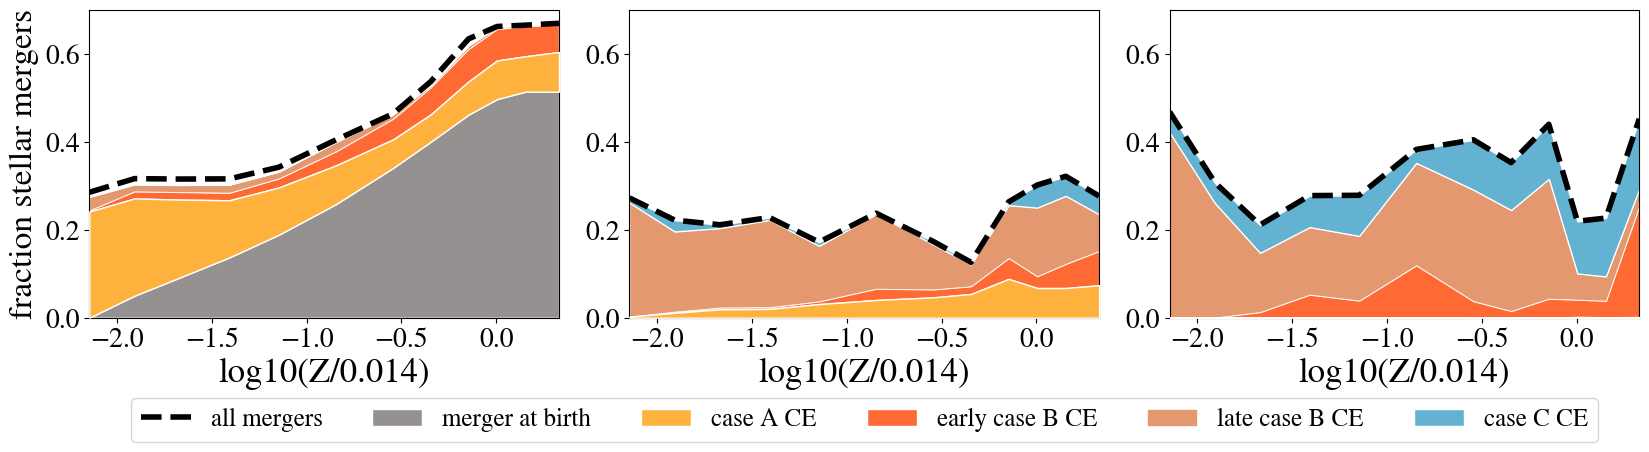

In [42]:
###########################################
# Create a figure
from matplotlib import hatch

fig = plt.figure(figsize=(20, 4))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)

# Create 3 small subplots on a line
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# List of panda tables of pot DCO progenitors
titles = ["BBH", "BHNS", "NSNS"]
dfs = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Loop over the axes and dataframes
for ax, df, title in zip(axes, dfs, titles):

    if channel_key == '_CHE':
        if title != 'BBH':
            continue

    ax.plot(1,1)
    N_tot_DCO_prog, N_mergers, N_first_mt1_is_merger, N_first_mt2_is_merger, N_optimistic_CE, N_merger_at_birth, case_ABC = get_merger_numbers(table = df)
    N_caseA_mergers, N_caseA_mergers_stable, N_caseA_mergers_CE, N_early_caseB_mergers, N_early_caseB_mergers_stable, N_early_caseB_mergers_CE, N_late_caseB_mergers, N_late_caseB_mergers_stable, N_late_caseB_mergers_CE, N_caseC_mergers, N_caseC_mergers_stable, N_caseC_mergers_CE = case_ABC

    # Normalize or abs numbers?
    norm = N_tot_DCO_prog #1. # 

    ax.plot(Z_Zsun, N_mergers/norm, color='k', label='all mergers', ls = '--', lw = 4,alpha = 1)

    bottom = np.zeros(len(Z_Zsun))

    # Stellar merger at birth 
    ax.fill_between(Z_Zsun, bottom/norm, N_merger_at_birth/norm, color='#959190', edgecolor='white', lw = 1, label='merger at birth', alpha = 1)
    bottom += N_merger_at_birth

    # Case A mergers
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseA_mergers_CE)/norm, color='#ffb13d',edgecolor='white', lw = 1, label='case A CE', alpha = 1, zorder = 10)
    bottom += N_caseA_mergers_CE

    # Early Case B mergers
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_early_caseB_mergers_CE)/norm, color='#FF6933', edgecolor='white', lw = 1, label='early case B CE', alpha = 1)
    bottom += N_early_caseB_mergers_CE

    # Late Case B mergers
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_late_caseB_mergers_CE)/norm, color='#e3986f', edgecolor='white', lw = 0.5, label='late case B CE', alpha = 1)
    # ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_late_caseB_mergers_CE)/norm, color='#b87a61', edgecolor='white', hatch = 'x', lw = 0.5, label='late case B CE', alpha = 1)
    bottom += N_late_caseB_mergers_CE

    # Case C mergers
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_caseC_mergers_CE)/norm, color='#64b2d1', edgecolor='white', lw = 1, label='case C CE', alpha = 1)
    # 284051 1B78AF
    
    # ax.plot(Z_Zsun, N_optimistic_CE, color='#BC0000', lw = 2, label='optimistic CE', alpha = 1)

    # ax.set_title(f'potential merging {title}', fontsize = 22) #7x{N_tot_DCO_prog[0.0001]}
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,0.7)
    ax.set_xlabel('log10(Z/0.014)', fontsize = 25)

#########################
# plotvalues
fig.subplots_adjust(wspace=0.15)

axes[0].set_ylabel("fraction stellar mergers", fontsize = 24)
axes[1].legend(bbox_to_anchor=(0.5, -0.22), loc='upper center', fontsize = 18, ncols = 6)

plt.savefig(f'../Figures/Stellar_mergers_{sim_name}{channel_key}_.pdf', bbox_inches='tight')
plt.show()
